### Preprocessing code.
Note: the .fastq files need to be merged (we used usearch11), stored in Merged/, with additional directories Filtered/ and Processed/ also stored in the same directory as this notebook.

In [1]:
#NeextGenSeqUtils is not a registered package, but you can install it with:
#using Pkg
#Pkg.add(PackageSpec(name="NextGenSeqUtils", rev="1.0", url = "https://github.com/MurrellGroup/NextGenSeqUtils.jl.git"))
using NextGenSeqUtils, PyPlot, StatsBase

In [2]:
function collapse(seqs; prefix = "")
    count_dic = countmap(seqs);
    keep_arr = sort([(count_dic[k],k) for k in keys(count_dic) if count_dic[k]>0],rev = true)
    return [prefix*"$(i)_$(ka[1])" for (i,ka) in enumerate(keep_arr)],[ka[2] for (i,ka) in enumerate(keep_arr)]
end

collapse (generic function with 1 method)

In [3]:
#These will be used to decide where the reads get trimmed, and how to orient them.
fwd_primer_options = uppercase.(["CTCGCGGCCCAGCCGGCCATGGCCGGCCCGGGAGCGGCCGCTCAGKTG","acttgcggccgctcagstg","cttgcggccgctcagstg"])
rev_primer_options = uppercase.(["accggcgcaccactagtgcaggcctggcgcgccgaggggtcttcgctgtggtgcgc",
                       "acgaggggtcttcgctgtggtgcgc",
                        "agcgcgccggttgtggttttggtgtcttgggttc",
                        "cgaggggtcttcgctgtggtgcgc",
                        "gcgcgccggttgtggttttggtgtcttgggttc"])

5-element Array{String,1}:
 "ACCGGCGCACCACTAGTGCAGGCCTGGCGCGCCGAGGGGTCTTCGCTGTGGTGCGC"
 "ACGAGGGGTCTTCGCTGTGGTGCGC"                               
 "AGCGCGCCGGTTGTGGTTTTGGTGTCTTGGGTTC"                      
 "CGAGGGGTCTTCGCTGTGGTGCGC"                                
 "GCGCGCCGGTTGTGGTTTTGGTGTCTTGGGTTC"                       

In [4]:
min_fwd = minimum(length.(fwd_primer_options))
min_rev = minimum(length.(rev_primer_options))
short_fwd = [p[1:min_fwd] for p in fwd_primer_options]
short_rev = [p[1:min_rev] for p in rev_primer_options];

In [5]:
merged_path = "Merged/"
filtered_path = "Filtered/"
processed_path = "Processed/"
fnames = [i for i in readdir(merged_path) if i[end-8:end] == "ged.fastq"]

4-element Array{String,1}:
 "Pre-TysonA_S1_L001_R1_001.fastq.merged.fastq" 
 "Pre-TysonB_S8_L001_R1_001.fastq.merged.fastq" 
 "RBD-flag-P1_S3_L001_R1_001.fastq.merged.fastq"
 "RBD-flag-P2_S6_L001_R1_001.fastq.merged.fastq"

RBD-flag-P2_S6_L001_R1_001.fastq.merged.fastq
Reading file...
Calculating filter...
Writing file...
RBD-flag-P1_S3_L001_R1_001.fastq.merged.fastq
Reading file...
Calculating filter...
Writing file...
Pre-TysonB_S8_L001_R1_001.fastq.merged.fastq
Reading file...
Calculating filter...
Writing file...
Pre-TysonA_S1_L001_R1_001.fastq.merged.fastq
Reading file...
Calculating filter...


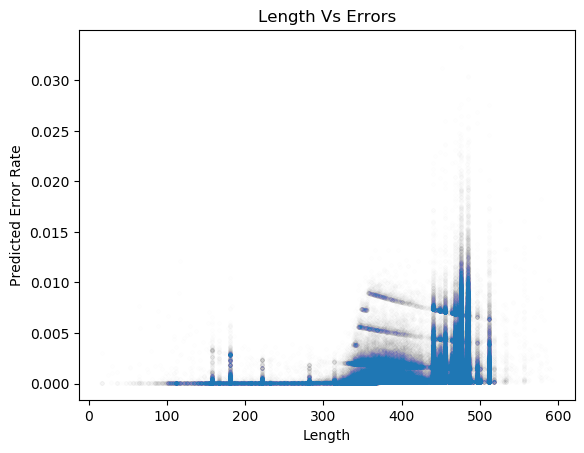

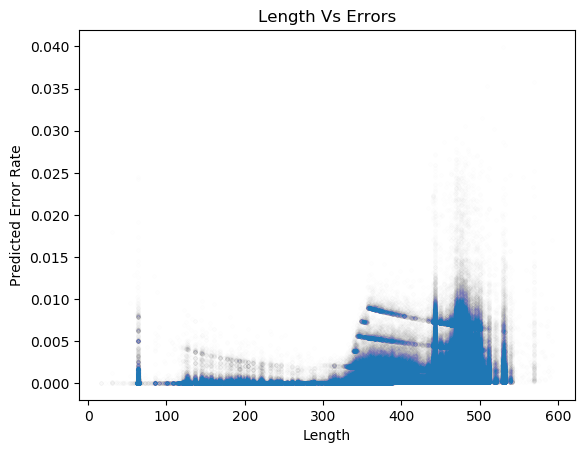

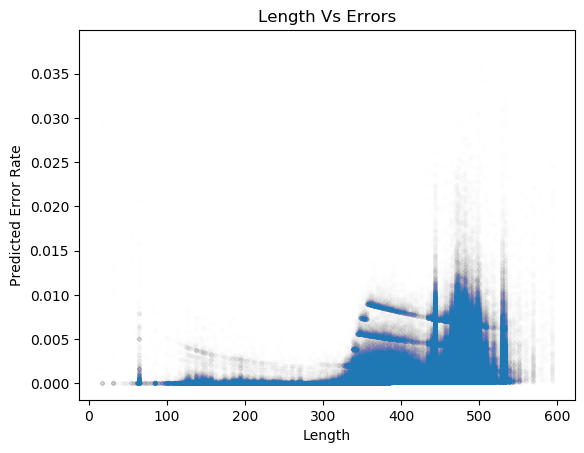

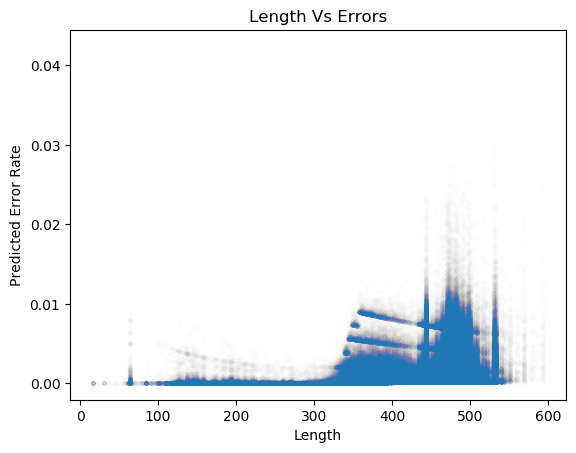

Writing file...


In [6]:
#This will take each file in "fnames" above, and:
#1: Filter for length and quality.
#2: Use a dictionary-based demux function to select reads with appropriate ends, and trim these.
#3: Collapse reads by identity (storing the count in the name), and export the full set (and the top 500 for visual inspection).
for fname in fnames[end:-1:1]
    println(fname)
    figure()
    length_vs_qual(merged_path*fname,alpha = 0.005);
    savefig(filtered_path*fname*"_LvQ.png")
    fastq_filter(merged_path*fname, filtered_path*fname*"_filt.fastq", error_rate = 0.01, min_length = 300);
    seqs,phreds,seqnames = read_fastq(filtered_path*fname*"_filt.fastq");
    demux_dic = demux_dict(seqs,short_fwd,short_rev,verbose=false,tol_one_error = true);

    trimmed_seqs = []
    for k in keys(demux_dic)
        push!(trimmed_seqs,[double_primer_trim(seqpair[1],fwd_primer_options[k[1]],rev_primer_options[k[2]]) for seqpair in demux_dic[k]])
    end

    seqs = vcat(trimmed_seqs...);
    outname = split(fname,"_S")[1]
    ka = collapse(seqs,prefix = outname*"_");
    write_fasta(processed_path*outname*".trimmed.fasta",ka[2],names = ka[1])
    write_fasta(processed_path*outname*".top500.trimmed.fasta",ka[2][1:500],names = ka[1][1:500])
end